In [41]:
# Mount drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Imports.
import matplotlib.pyplot as plt
import numpy as np
import os
import itertools
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import models, activations, losses, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Lambda, Reshape
from keras.callbacks import ModelCheckpoint

In [102]:
# Inputs
image_dimension = 128     # Size of the images (e.g. 128 for a 128x128 image)
directory = os.getcwd() + '/drive/My Drive/Face_Verification_Project/people' 
test_directory = os.getcwd() + '/drive/My Drive/Face_Verification_Project/test_images/' 
training_epochs = 60

In [103]:
def images_to_list(path, dims) :
    """
    Converts all the images in a given directory to numerical values.

    Inputs:
      path (str): Directory to the folder that contains the images.
      dims (int): Target size of the images (width and height)
    Output:
      images (list): A list of numpy arrays, each array represinting an image.
    """
    images = []
    for image_path in os.listdir(path):
        image = tf.keras.preprocessing.image.load_img(os.path.join(path, image_path))
        image = image.resize((dims, dims))
        image = np.swapaxes(np.asarray(image), 0, 1) / 255
        images.append(image)
    return images

In [104]:
def data_pre_processing(path, dims):
    """
    Process the input of the face verification model.

    Inputs:
      path (str): Directory to the folder containing the face images. The 
                  directory must contain the face of each person.
      dims (int): Target size of the images (width and height)
    Output:
      CNN Input: Three arrays, containing the faces 
    """
    
    # Image Pre-processing
    images, labels = [], []
    for i, person in enumerate(os.listdir(path)):
        local_path = os.path.join(path, person)
        images += images_to_list(local_path, dims)      
        labels += [i]*len(os.listdir(local_path))
    images = np.array(images)
    
    # Combinations and Labels.
    array_1 = array_2 = [i for i in range(len(labels))]
    mesh = np.array(np.meshgrid(array_1, array_2))
    combinations = mesh.T.reshape(-1, 2)
    C1, C2 = [images[i[0]] for i in combinations], [images[i[1]] for i in combinations]
    Y = np.array([labels[c[0]] == labels[c[1]] for c in combinations]).astype(int)
           
    # Return.
    return C1, C2, Y

In [105]:
def list_to_flatten(list_of_images, dims):
    images = np.array(list_of_images)
    images = images.reshape((images.shape[0], (dims**2)*3)).astype(np.float32)
    return images

In [106]:
# CNN Models
input_shape = ((image_dimension**2) * 3 ,)

# Test Model
BasicNet = tf.keras.Sequential([
        Reshape(input_shape=input_shape, target_shape=(image_dimension, image_dimension, 3)),
        Conv2D(32, kernel_size=(4, 4), strides=1, activation='relu'),
        Conv2D(32, kernel_size=(4, 4), strides=1, activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=1),
        Conv2D(64, kernel_size=(3, 3), strides=1, activation='relu'),
        Conv2D(64, kernel_size=(3, 3), strides=1, activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=1),
        Flatten(),
        Dense(32, activation=activations.sigmoid)])

# LENET50 
LeNet5 = tf.keras.models.Sequential([
          Reshape(input_shape=input_shape, target_shape=(image_dimension, image_dimension, 3)),
          tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'),
          tf.keras.layers.AveragePooling2D(),
          tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
          tf.keras.layers.AveragePooling2D(),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(units=120, activation='relu'),
          tf.keras.layers.Dense(units=84, activation='relu'),
          tf.keras.layers.Dense(units=10, activation = 'softmax')])


# Define the CNN model to be used
selected_model = LeNet5

In [107]:
# CNN model function
def cnn_model(dims):
    input_shape = ((dims**2) * 3 ,)
    seq_model = selected_model
    input_x1, input_x2 = Input(shape=input_shape), Input(shape=input_shape)
    output_x1, output_x2 = seq_model(input_x1), seq_model(input_x2)
    distance_euclid = Lambda(lambda t: K.abs(t[0] - t[1]))([output_x1 , output_x2])
    outputs = Dense(1, activation=activations.sigmoid)(distance_euclid)
    return models.Model([input_x1 , input_x2], outputs)

In [108]:
# CODE
C1, C2, Y = data_pre_processing(directory, image_dimension)
C1, C2 = list_to_flatten(C1, image_dimension), list_to_flatten(C2, image_dimension)
X = [C1, C2]

In [109]:
# Extras.
checkpoint = ModelCheckpoint('model_' + str(image_dimension) + '.h5', verbose=1, monitor='loss', 
                              save_best_only=True, mode='auto')
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

# Model training.
model = cnn_model(image_dimension)
model.compile(loss=losses.binary_crossentropy , optimizer=optimizers.Adam(learning_rate = 0.0001))
history = model.fit(X, Y, batch_size=1, epochs=training_epochs, callbacks=[lr_schedule])

Epoch 1/60
100/100 [==============================] - 0s 4ms/step - loss: 0.6926
Epoch 2/60
100/100 [==============================] - 0s 4ms/step - loss: 0.6901
Epoch 3/60
100/100 [==============================] - 0s 4ms/step - loss: 0.6874
Epoch 4/60
100/100 [==============================] - 0s 4ms/step - loss: 0.6835
Epoch 5/60
100/100 [==============================] - 0s 4ms/step - loss: 0.6769
Epoch 6/60
100/100 [==============================] - 0s 4ms/step - loss: 0.6609
Epoch 7/60
100/100 [==============================] - 0s 4ms/step - loss: 0.6166
Epoch 8/60
100/100 [==============================] - 0s 4ms/step - loss: 0.5648
Epoch 9/60
100/100 [==============================] - 0s 4ms/step - loss: 0.5427
Epoch 10/60
100/100 [==============================] - 0s 4ms/step - loss: 0.5347
Epoch 11/60
100/100 [==============================] - 0s 4ms/step - loss: 0.5314
Epoch 12/60
100/100 [==============================] - 0s 4ms/step - loss: 0.5294
Epoch 13/60
100/100 [====

In [110]:
# Testing.

# Array preparation.
test_images = images_to_list(test_directory, image_dimension)
test_images = list_to_flatten(test_images, image_dimension)
   
labels = [[e]*len(os.listdir(directory + '/' + i)) for e, i in enumerate(os.listdir(directory))]
labels = list(itertools.chain.from_iterable(labels))
training_images = C2[:len(labels), :]

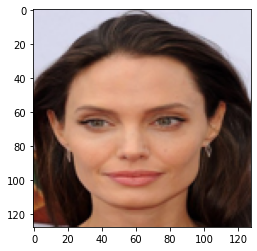

IMAGE 0 is Angelina with confidence of 89.97%


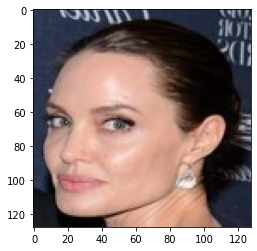

IMAGE 1 is Angelina with confidence of 90.22%


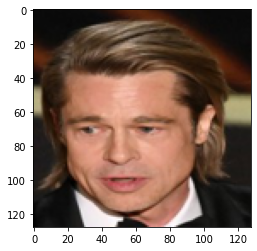

IMAGE 2 is Brad with confidence of 90.18%


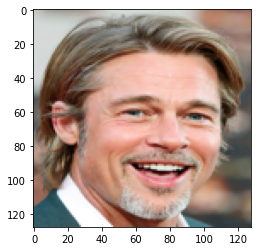

IMAGE 3 is Brad with confidence of 90.2%


In [111]:
# Predict.
names = ['Angelina', 'Brad']
for e, tensor in enumerate(test_images):
    
    # Show image.
    plt.imshow(np.rot90(tensor.reshape((image_dimension, image_dimension, 3)), k=-1))
    plt.show()
    
    # Predict scores.
    scores = [model.predict([tensor.reshape((1, -1)), sample.reshape((1, -1))])[0]  for sample in training_images]
    
    # Find the largest score, and its corresponding index.
    idx = np.argmax(scores)
    label = labels[idx]
    name = names[label] 
    print( 'IMAGE {} is {} with confidence of {}%'.format(e, name, round(100*scores[idx][0], 2)))